In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from DAFD.metrics_study.metric_utils import *
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from tqdm import tqdm

Using TensorFlow backend.
c:\users\dpmci\miniconda3\envs\dafd\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\dpmci\miniconda3\envs\dafd\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\dpmci\miniconda3\envs\dafd\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\dpmci\miniconda3\envs\dafd\lib\site-pa

regime classifier
Loading classifier
Train accuracy: 0.9887387387387387

Regression model generation_rate2
Loading Regressor
R square (R^2) for Train:                 0.987384

Regression model droplet_size2
Loading Regressor
R square (R^2) for Train:                 0.983142

Regression model generation_rate1
Loading Regressor
R square (R^2) for Train:                 0.965872

Regression model droplet_size1
Loading Regressor
R square (R^2) for Train:                 0.953238

regime classifier
Loading classifier
Train accuracy: 0.9887387387387387

Regression model generation_rate2
Loading Regressor
R square (R^2) for Train:                 0.987384

Regression model droplet_size2
Loading Regressor
R square (R^2) for Train:                 0.983142

Regression model generation_rate1
Loading Regressor
R square (R^2) for Train:                 0.965872

Regression model droplet_size1
Loading Regressor
R square (R^2) for Train:                 0.953238



In [2]:
orthogonal_devices = pd.read_csv("DAFD/metrics_study/orthogonal_devices.csv")

Run versatility analysis on 25 orthogonal devices and plot design space coverage

In [6]:
devices[[]]

[{'Chip #': 1.0,
  'orifice_size': 75.0,
  'aspect_ratio': 1.0,
  'expansion_ratio': 2.0,
  'normalized_water_inlet': 2.0,
  'normalized_oil_inlet': 2.0,
  'normalized_orifice_length': 1.0},
 {'Chip #': 2.0,
  'orifice_size': 75.0,
  'aspect_ratio': 1.5,
  'expansion_ratio': 3.0,
  'normalized_water_inlet': 2.5,
  'normalized_oil_inlet': 2.5,
  'normalized_orifice_length': 1.5},
 {'Chip #': 3.0,
  'orifice_size': 75.0,
  'aspect_ratio': 2.0,
  'expansion_ratio': 4.0,
  'normalized_water_inlet': 3.0,
  'normalized_oil_inlet': 3.0,
  'normalized_orifice_length': 2.0},
 {'Chip #': 4.0,
  'orifice_size': 75.0,
  'aspect_ratio': 2.5,
  'expansion_ratio': 5.0,
  'normalized_water_inlet': 3.5,
  'normalized_oil_inlet': 3.5,
  'normalized_orifice_length': 2.5},
 {'Chip #': 5.0,
  'orifice_size': 75.0,
  'aspect_ratio': 3.0,
  'expansion_ratio': 6.0,
  'normalized_water_inlet': 4.0,
  'normalized_oil_inlet': 4.0,
  'normalized_orifice_length': 3.0},
 {'Chip #': 6.0,
  'orifice_size': 100.0,
  '

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:10<00:00,  2.51it/s]


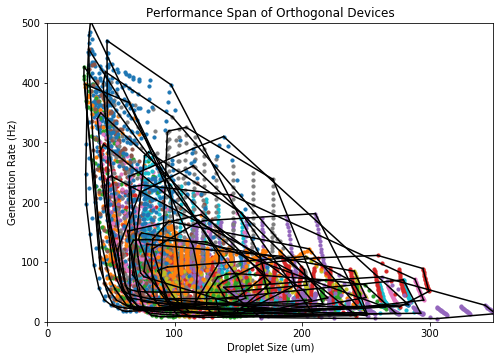

In [5]:
devices = orthogonal_devices.to_dict(orient='records')
score = []
size_score = []
rate_score = []
all_points = {}
hulls = []

plt.figure(figsize=[8,5.5])
for device in tqdm(devices):
    features = device.copy()
    chip_num = features["Chip #"]
    del features["Chip #"]
    sizes, rates, _ = sweep_results(device, sweep_size=25, jet_drop=False, ca_range=[.05, .4])
    size_score.append(np.max(sizes) - np.min(sizes))
    rate_score.append(np.max(rates) - np.min(rates))
    points = np.array([[sizes[i], rates[i]] for i in range(len(sizes))])
    all_points[chip_num] = points
    hull = ConvexHull(points)
    hulls.append(hull)
    plt.scatter(points[:,0], points[:,1], s=10)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    score.append(hull.volume)
orthogonal_devices["hull_object"] = hulls
plt.xticks([0, 100, 200, 300])
plt.xlabel("Droplet Size (um)")
plt.ylabel("Generation Rate (Hz)")
plt.xlim([0, 350])
plt.ylim([0, 500])
plt.title("Performance Span of Orthogonal Devices")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig("20220810_min_devices.pdf")

Calculate minimal orthogonal devices needed to cover design space

In [7]:
# Making minimal setup
target = 0.99
coverage = 0.0
hulls = orthogonal_devices["hull_object"].to_dict()
devices_left = len(hulls)
points_left = []
points_used = []
used = []
areas = list(np.zeros(len(hulls)))

for key in all_points.keys():
    points_left.extend(all_points[key])
area_left = ConvexHull(points_left).volume
design_space_area = area_left

count = 1
while coverage <= target or count < 25:
    print(count)
    ## 1.1 Calculate area of each device hull
    for key in hulls:
        if key not in used:
            areas[key] = hulls[key].volume
    ## 1.2 pick hull with maximum area
    max_chip = areas.index(max(areas)) #requires 2 iterations but list is small
    used.append(max_chip)
    ## 1.3 remove all points WITHIN hull (& add to min dataset). This is for the full devices and for any overlaps
    points_left = []
    for chip_num in all_points.keys():
        points_placeholder = []
        for i, point in enumerate(all_points[chip_num]):
            if not in_hull(point, hulls[max_chip].points):
                points_placeholder.append(point)
            else:
                points_used.append(point)
        all_points[int(chip_num)] = np.array(points_placeholder) # Delete point if it is inside of the current point
        points_left.extend(all_points[chip_num])
        if chip_num-1 in used or len(all_points[chip_num]) < 3:
            areas[int(chip_num)-1] = -1
            if chip_num - 1 not in used:
                used.append(chip_num-1)
        else:
            hulls[int(chip_num)-1] = ConvexHull(all_points[chip_num])
        
    area_left = ConvexHull(points_used).volume
    coverage = area_left/design_space_area
    print("Iteration %f, Coverage %f" % (count, coverage))
    count+=1
    if count > 25:
        break
    if coverage >= 0.99:
        break

1
Iteration 1.000000, Coverage 0.499869
2
Iteration 2.000000, Coverage 0.620618
3
Iteration 3.000000, Coverage 0.783382
4
Iteration 4.000000, Coverage 0.992413


Plot minimal devices to visualize overlap and design space coverage

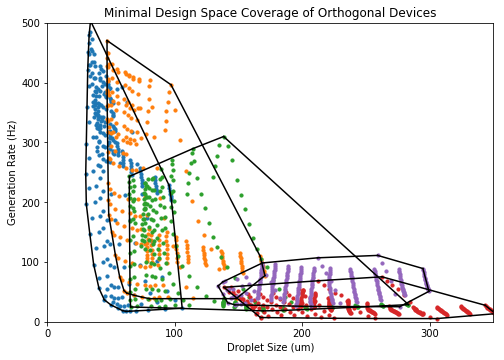

In [11]:
plt.figure(figsize=[8,5.5])

for i in [1,11,21,25,24]:
    points = all_points[i]
    hull = ConvexHull(points)
    hulls.append(hull)
    plt.scatter(points[:,0], points[:,1], s=10)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        
plt.xticks([0, 100, 200, 300])
plt.xlabel("Droplet Size (um)")
plt.ylabel("Generation Rate (Hz)")
plt.xlim([0, 350])
plt.ylim([0, 500])
plt.title("Minimal Design Space Coverage of Orthogonal Devices")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig("20220810_min_devices.pdf")

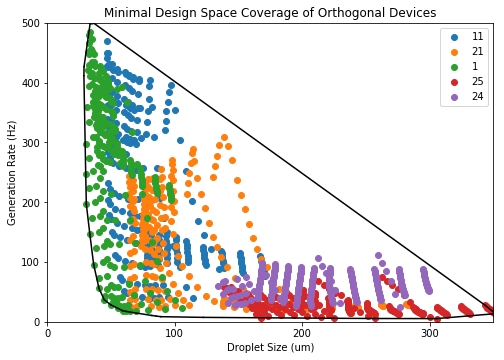

In [7]:
entire_space = []
for key in all_points.keys():
    entire_space.extend(all_points[key])
entire_space= np.array(entire_space)
design_space_hull = ConvexHull(entire_space)

plt.figure(figsize=[8,5.5])
plt.scatter(all_points[11][:,0], all_points[11][:,1])
plt.scatter(all_points[21][:,0], all_points[21][:,1])
plt.scatter(all_points[1][:,0], all_points[1][:,1])
# plt.scatter(all_points[22][:,0], all_points[22][:,1])
# plt.scatter(all_points[3][:,0], all_points[3][:,1])

plt.scatter(all_points[25][:,0], all_points[25][:,1])
plt.scatter(all_points[24][:,0], all_points[24][:,1])

#plt.legend(["11", "21", "1", "25", "24"])
plt.title("Minimal Design Space Coverage of Orthogonal Devices")
plt.xticks([0, 100, 200, 300])
plt.xlabel("Droplet Size (um)")
plt.ylabel("Generation Rate (Hz)")
for simplex in design_space_hull.simplices:
    plt.plot(entire_space[simplex, 0], entire_space[simplex, 1], 'k-')

plt.xlim([0, 350])
plt.ylim([0, 500])
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#plt.savefig("20220810_minimal_plots.pdf")

# Training DAFD on Orthogonal Devices

In [21]:
data = pd.read_csv("DAFD/helper_scripts/experimental_data/ExperimentalResults_888.csv").round(2)

#C:\Users\dpmci\OneDrive\Documents\Lab\Repo\DAFD\DAFD\helper_scripts\experimental_data

In [23]:
def groupByChip(data):
    removed = ["droplet_size", "generation_rate", "regime",
               "capillary_number", "flow_rate_ratio"]
    group_vars = [col for col in data.columns if col not in removed]
    data = pd.concat([data, pd.DataFrame(np.zeros(len(data)), columns=["Chip"])], axis=1)

    print(group_vars)
    chips = data.groupby(group_vars).groups
    for i, chip in enumerate(chips.keys()):
        data.loc[chips[chip], "Chip"] = i
    return data, pd.DataFrame(list(chips.keys()), columns=group_vars)

In [33]:
data.columns

Index(['chip_number', 'orifice_size', 'aspect_ratio', 'expansion_ratio',
       'normalized_orifice_length', 'normalized_water_inlet',
       'normalized_oil_inlet', 'flow_rate_ratio', 'capillary_number', 'regime',
       'generation_rate', 'droplet_size'],
      dtype='object')

In [37]:
gr = data.groupby(["orifice_size", "aspect_ratio", 'expansion_ratio',
       'normalized_orifice_length', 'normalized_water_inlet',
       'normalized_oil_inlet'])

In [45]:
list(gr.groups.keys())

[(75, 1.0, 2.0, 1.0, 2.0, 2.0),
 (75, 1.0, 2.19, 1.0, 2.01, 2.15),
 (75, 1.25, 2.19, 1.15, 2.04, 2.28),
 (75, 1.5, 3.0, 1.5, 2.5, 2.5),
 (75, 2.0, 4.0, 2.0, 3.0, 3.0),
 (75, 2.02, 4.02, 2.06, 3.04, 2.94),
 (75, 2.5, 5.0, 2.5, 3.5, 3.5),
 (75, 3.0, 5.89, 3.0, 4.0, 3.98),
 (75, 3.0, 6.0, 3.0, 4.0, 4.0),
 (100, 1.0, 3.0, 2.0, 3.5, 4.0),
 (100, 1.5, 4.0, 2.5, 4.0, 2.0),
 (100, 1.96, 4.87, 2.97, 2.0, 2.44),
 (100, 1.99, 4.97, 3.0, 2.01, 2.49),
 (100, 2.0, 5.0, 3.0, 2.0, 2.5),
 (100, 2.5, 6.0, 1.0, 2.5, 3.0),
 (100, 2.81, 2.0, 1.5, 2.99, 3.58),
 (100, 3.0, 2.0, 1.5, 3.0, 3.5),
 (125, 1.0, 4.0, 3.0, 2.5, 3.5),
 (125, 1.13, 4.1, 3.0, 2.55, 3.55),
 (125, 1.5, 5.0, 1.0, 3.0, 4.0),
 (125, 2.0, 6.0, 1.5, 3.5, 2.0),
 (125, 2.49, 6.0, 1.27, 3.74, 2.06),
 (125, 2.5, 2.0, 2.0, 4.0, 2.5),
 (125, 3.0, 3.0, 2.5, 2.0, 3.0),
 (150, 1.0, 5.0, 1.5, 4.0, 3.0),
 (150, 1.5, 6.0, 2.0, 2.0, 3.5),
 (150, 2.0, 2.0, 2.5, 2.5, 4.0),
 (150, 2.5, 3.0, 3.0, 3.0, 2.0),
 (150, 2.51, 3.0, 3.0, 2.99, 2.0),
 (150, 3.0, 4.0, 

In [43]:
cols = ["orifice_size", "aspect_ratio", 'expansion_ratio',
       'normalized_orifice_length', 'normalized_water_inlet',
       'normalized_oil_inlet']
list(orthogonal_devices.loc[:, cols].itertuples(index=False, name=None))


[(75, 1.0, 2, 1.0, 2.0, 2.0),
 (75, 1.5, 3, 1.5, 2.5, 2.5),
 (75, 2.0, 4, 2.0, 3.0, 3.0),
 (75, 2.5, 5, 2.5, 3.5, 3.5),
 (75, 3.0, 6, 3.0, 4.0, 4.0),
 (100, 1.0, 3, 2.0, 3.5, 4.0),
 (100, 1.5, 4, 2.5, 4.0, 2.0),
 (100, 2.0, 5, 3.0, 2.0, 2.5),
 (100, 2.5, 6, 1.0, 2.5, 3.0),
 (100, 3.0, 2, 1.5, 3.0, 3.5),
 (125, 1.0, 4, 3.0, 2.5, 3.5),
 (125, 1.5, 5, 1.0, 3.0, 4.0),
 (125, 2.0, 6, 1.5, 3.5, 2.0),
 (125, 2.5, 2, 2.0, 4.0, 2.5),
 (125, 3.0, 3, 2.5, 2.0, 3.0),
 (150, 1.0, 5, 1.5, 4.0, 3.0),
 (150, 1.5, 6, 2.0, 2.0, 3.5),
 (150, 2.0, 2, 2.5, 2.5, 4.0),
 (150, 2.5, 3, 3.0, 3.0, 2.0),
 (150, 3.0, 4, 1.0, 3.5, 2.5),
 (175, 1.0, 6, 2.5, 3.0, 2.5),
 (175, 1.5, 2, 3.0, 3.5, 3.0),
 (175, 2.0, 3, 1.0, 4.0, 3.5),
 (175, 2.5, 4, 1.5, 2.0, 4.0),
 (175, 3.0, 5, 2.0, 2.5, 2.0)]

In [53]:
t  = my_orth[0]
to_comp = list(gr.groups.keys()) 
[t==comp for comp in to_comp]

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [63]:
my_orth = list(orthogonal_devices.loc[:, cols].itertuples(index=False, name=None))
to_comp = list(gr.groups.keys())
out = {}
for i, x in enumerate(my_orth):
    for y in to_comp:
        if x == y:
            out[i+1] = gr.get_group(y)
            

In [64]:
ortho_boys = [11,21, 1, 25, 24]
reduced_data = None
for i,x in enumerate(ortho_boys):
    to_add = out[x]
    if i == 0:
        reduced_data = to_add.copy()
    else:
        reduced_data = pd.concat([reduced_data, to_add])

In [67]:
from DAFD.bin.ForwardModelTester import ForwardModelTester

regime classifier
Loading classifier
Train accuracy: 0.9887387387387387

Regression model generation_rate2
Loading Regressor
R square (R^2) for Train:                 0.987384

Regression model droplet_size2
Loading Regressor
R square (R^2) for Train:                 0.983142

Regression model generation_rate1
Loading Regressor
R square (R^2) for Train:                 0.965872

Regression model droplet_size1
Loading Regressor
R square (R^2) for Train:                 0.953238



In [ ]:
from DAFD.models.forward_models.NeuralNetModel_rate1 import NeuralNetModel_rate1
from DAFD.models.forward_models.NeuralNetModel_rate2 import NeuralNetModel_rate2
from DAFD.models.forward_models.NeuralNetModel_size1 import NeuralNetModel_size1
from DAFD.models.forward_models.NeuralNetModel_size2 import NeuralNetModel_size2


nn_r1 = NeuralNetModel_rate1()
nn_r2 = NeuralNetModel_rate2()
nn_s1 = NeuralNetModel_size1()
nn_s2 = NeuralNetModel_size2()


In [68]:
reduced_data.to_csv("20220802_ORTHOGONAL_TRAINING_DATA.csv")

In [69]:
test = pd.read_csv("DAFD/helper_scripts/experimental_data/ExperimentalResults_888.csv").round(2)


In [70]:
test.columns

Index(['chip_number', 'orifice_size', 'aspect_ratio', 'expansion_ratio',
       'normalized_orifice_length', 'normalized_water_inlet',
       'normalized_oil_inlet', 'flow_rate_ratio', 'capillary_number', 'regime',
       'generation_rate', 'droplet_size'],
      dtype='object')

In [72]:
reduced_data.loc[:, test.columns].to_csv("20220802_ORTHOGONAL_TRAINING_DATA.csv")